# Experiments in neural multivariate population codes - Noise correlations
Code adapted from S. Keemink & M. van Rossum ([paper](http://biorxiv.org/content/biorxiv/early/2017/03/04/113803.full.pdf))

In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [2]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [9]:
# Restore session state i.e. all objects
# dill.load_session('session_state.pkl')

# Save current session state
# Unix compress file: $ gzip session_state.pkl
# dill.dump_session('session_state.pkl')

### Setting up population coding model

We are using a homogeneous model with broad, bell-shaped tuning curves uniformly distributed over the stimulus space.

We have a population of $N$ neurons with identical tuning curves:
$$g_i(s)=A\exp\Bigg[-\frac{(s-\phi_i)^2}{2\omega^2}\Bigg]$$

where the symbols correspond to:
* $A$ - Amplitude (maximum firing rate; baseline firing rate assumed to be zero)
* $s$ - Stimulus (orientation; one-dimensional quantity)
* $\phi_i$ - Preferred stimulus for neuron $i$ in range $[-\pi, \pi]$
* $\omega$ - Width of tuning curve

Dense coding assumption; we require $\frac{2\pi}{N} \ll \omega$ 

Note: Currently, we are modelling orientation selectivity using a Gaussian (non-circular) tuning curve. Plan to add experiments using a von Mises (circular Gaussian) tuning curve later.

In [4]:
# Tuning curve parameters
N_NEURONS = 100
AMPLITUDE = 1.0
TUNING_WIDTH = 0.5

# Array of orientations corresponding to neurons' preferred stimuli
PREF_STIMS = np.linspace(-pi, pi, N_NEURONS+1)[:-1]

def tuning_curve(pref_stim, stimulus):
    return AMPLITUDE * exp( - (stimulus - pref_stim)**2 / (2 * TUNING_WIDTH**2) )

### Modelling response to multivariate stimuli

We consider a 2-dimensional stimulus $\mathbf{s} = (s_1, s_2)$ and model the average response of a neuron using the linear coding model ([Treue et al. 2000](http://www.nature.com/neuro/journal/v3/n3/abs/nn0300_270.html)):
$$f_i(\mathbf{s})=g_i(s_1)+g_i(s_2)$$

Next, we redefine the system in terms of the sum ($\eta$) and difference ($\Theta$) of the angles in the 2-dimensional stimulus.

We concentrate on the difference or opening angle, defined as $\Theta = s_2 - s_1$, such that the tuning of neuron $i$ becomes:
$$f_i(\Theta)=g_i(\Theta/2)+g_i(-\Theta/2)$$

In [5]:
def tuning_curve_2d(pref_stim, stim_1, stim_2):
    return tuning_curve(pref_stim, stim_1) + tuning_curve(pref_stim, stim_2)

def tuning_curve_theta(pref_stim, opening_angle):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2)

## Simulating trial-to-trial variability

We model the stochasticity in trial-to-trial neuron responses by adding a Gaussian noise term to the (average) population response given by the neurons' tuning curves.

The population response (N-dimensional vector) to a stimulus $\Theta$ is given by: $\mathbf{r} = \mathbf{f}(\Theta) + \mathbf{v}$

where:
* $\mathbf{f}(\Theta)$ - average population response; $(f_1(\Theta), ..., f_N(\Theta))^T$
* $\mathbf{v}$ - Gaussian noise term $\mathbf{v} \sim \mathcal{N}(\mathbf{0}, Q)$ where 
    * $Q$ - covariance matrix which models correlations in the trial-to-trial variability of neuron responses (*noise correlations*)

### Limited range correlation noise model

We begin with the limited range correlation model in which neurons with similar stimulus preferences have greater noise correlations.

Firstly, we generate the matrix (NxN) of functional distances representing the pairwise (circular) distances between preferred stimuli.

The distances are computed using the expression: $\phi_j - \phi_k = \arg \exp[i(\phi_j - \phi_k)]$

In [6]:
# Standard deviation of noise
NOISE_SIGMA = 0.2 # TODO: Do we want to keep this constant?

In [7]:
PREF_ANG_DISTS = PREF_STIMS - PREF_STIMS[:,None] # (N,N)
PREF_ANG_DISTS = absolute(angle(exp(1j * PREF_ANG_DISTS))) # in range [0,pi]

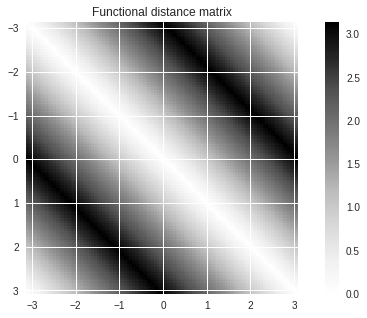

In [8]:
data_coords = [PREF_STIMS[0], PREF_STIMS[-1], PREF_STIMS[-1], PREF_STIMS[0]]
plt.imshow(PREF_ANG_DISTS, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Functional distance matrix')

Then we construct the correlation matrix, $R$, using the functional distances.

The matrix has the form: $r_{jk} = c(|\phi_j - \phi_k|) + \delta_{jk}(1 - c(0))$ 
where 
$$c(|\phi_j - \phi_k|) = c_0 \exp(-\frac{|\phi_j - \phi_k|}{L})$$

We introduce two correlation parameters:
* $c_0$ - Max correlation
* $L$ - Correlation length

The covariance matrix, $Q$, is constructed as follows: $Q = SRS$

where $S = \sigma I_N$ i.e. uniform variance across neurons

In [9]:
def construct_corr_matrix(max_corr, corr_length):
    return max_corr * (exp(-PREF_ANG_DISTS / corr_length) - eye(N_NEURONS)) + eye(N_NEURONS)

def construct_cov_matrix(max_corr=1.0, corr_length=0.5):
    corr_mtx = construct_corr_matrix(max_corr, corr_length)
    stds_mtx = NOISE_SIGMA * eye(N_NEURONS) # matrix of standard deviations
    return dot(stds_mtx, dot(corr_mtx, stds_mtx))

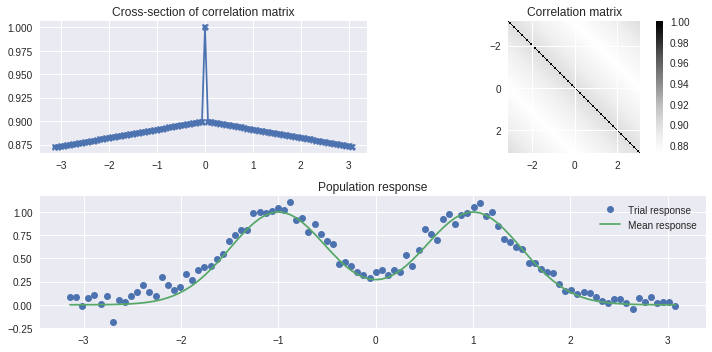

In [11]:
# Visualisation of correlation matrix
max_corr = 0.9
corr_length = 100

# Cross-section of correlation matrix
plt.subplot(221) 
corr_mtx = construct_corr_matrix(max_corr, corr_length)
plt.plot(PREF_STIMS, corr_mtx[50], '-X')
plt.title('Cross-section of correlation matrix')

# Correlation matrix
plt.subplot(222) 
data_coords = [PREF_STIMS[0], PREF_STIMS[-1], PREF_STIMS[-1], PREF_STIMS[0]]
plt.imshow(corr_mtx, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Correlation matrix')

# Population response
plt.subplot(212)
# sample population response
stim = 2.0
mean_pop_res = tuning_curve_theta(PREF_STIMS, stim)
cov_mtx = construct_cov_matrix(max_corr, corr_length)
pop_res = np.random.multivariate_normal(mean_pop_res, cov_mtx)
plt.plot(PREF_STIMS, pop_res, 'o', label='Trial response')
plt.plot(PREF_STIMS, mean_pop_res, label='Mean response')
plt.legend()
plt.title('Population response')

plt.tight_layout()

## Maximum Likelihood decoding

After specifying the correlation parameters $(c_0, L)$, we construct a covariance matrix.

We can then generate (noisy) population responses by sampling from the multivariate Gaussian distribution $\mathbf{r} \sim \mathcal{N}(\mathbf{f}(\Theta), Q)$

The distribution has the probability density function:
$$p(\mathbf{r} | \Theta) = \frac{1}{\sqrt{(2\pi)^N \det{Q}}} \exp{\Big\{-\frac{1}{2}[\mathbf{r} - \mathbf{f}(\Theta)]^T Q^{-1} [\mathbf{r} - \mathbf{f}(\Theta)]\Big\}}$$

For some noisy population response $\mathbf{r}$, we can compute an estimate $\hat{\theta}$ using the maximum likelihood decoder.

i.e. we choose the candidate stimulus $\theta$ which maximises the probability that the stimulus generated the response (*likelihood*)

$$\hat{\theta} = \arg \max_{\theta}{\log{p(\mathbf{r} | \theta)}}$$

We can ignore terms independent of $\theta$ as they do not contribute to the ML estimate. Hence, we have the form:

$$\hat{\theta} = \arg \min_{\theta}{\Big\{ [\mathbf{r} - \mathbf{f}(\Theta)]^T Q^{-1} [\mathbf{r} - \mathbf{f}(\Theta)]\Big\}}$$

To determine the ML estimate, we use a *brute-force* approach in which the likelihood function (or more accurately the simplied *error* function) is evaluated at every point in a fine-spaced grid of parameter values (i.e. candidate stimuli).

The candidate stimulus which gives rise to the minimum error is the estimate.

In [12]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

In [13]:
# TODO: Seed random number generator to get repeatable results

# Simulates noisy responses then proceeds to decoding them
def get_ML_ests(cov_mtx, n_realisations=5000):
    # realisation = simulated population response
    
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))
    
    # Simulate neuron responses followed by decoding for each stimulus in THETAS
    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]
                
        # Generate noisy pop. responses by sampling multivariate distribution
        avg_pop_res = tuning_curve_theta(PREF_STIMS, stim)
        pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)
                
        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(PREF_STIMS, CAND_ESTS[:,None])
        tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
        errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))
        
        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]
        
        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()

    return [estimate_dists, biases, variances]

## Simulations
#### Simulation 1: vary max correlation

* Max correlation: $c_0 \in [0,1]$ with steps of 0.1
* Correlation length: $L = 0.5$

Note that $c_0 = 0$ is equivalent to independent neurons (uncorrelated).

In [14]:
# Generates string label representing correlation parameters (used for dictionary label)
def get_corr_param_dict_lbl(max_corr, corr_length):
    return 'max_corr='+str(max_corr)+';corr_length='+str(corr_length)

In [33]:
corr_length = 0.5
max_corr_arr = np.linspace(0.0, 1.0, 11)

ML_ests = dict()
for max_corr in max_corr_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

In [35]:
ML_ests_1 = ML_ests

#### Simulation 2: vary correlation length
* Max correlation: $c_0 \in \{0.25, 0.5, 0.75, 1\}$
* Correlation length: $L \in [0.1,1]$ with steps of 0.1

In [36]:
max_corr_arr = np.linspace(0.0, 1.0, 5)[1:]
corr_length_arr = np.linspace(0.0, 1.0, 11)[1:]

ML_ests = dict()
for max_corr in max_corr_arr:
    for corr_length in corr_length_arr:
        cov_mtx = construct_cov_matrix(max_corr, corr_length)
        lbl = get_corr_param_dict_lbl(max_corr, corr_length)
        ML_ests[lbl] = get_ML_ests(cov_mtx)

In [55]:
ML_ests_2 = ML_ests

### Plots & Analysis

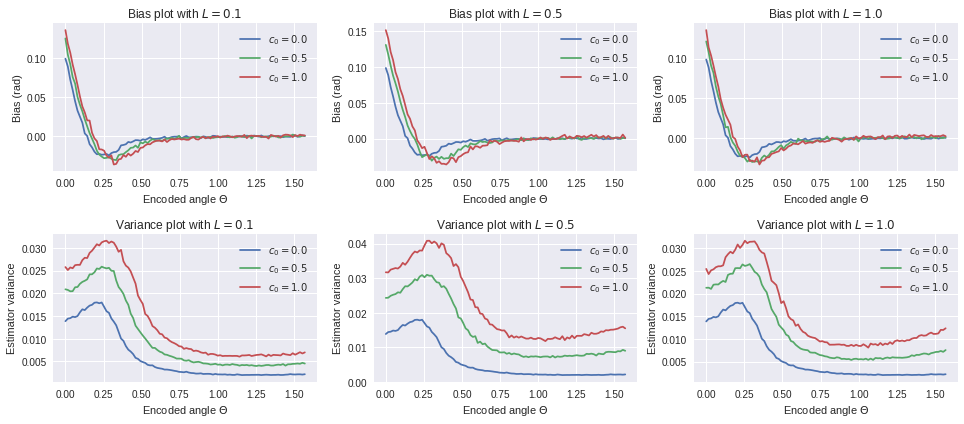

In [15]:
max_corr_plot = [0.0, 0.5, 1.0]

plt.rcParams['figure.figsize'] = (13.5, 6)

corr_length = 0.1
# Top-Left - Bias plot; L=0.1; c0={0.0,0.5,1.0}; Sim2
plt.subplot(231)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(0.0))
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_2[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Left - Variance plot; L=0.1; c0={0.0,0.5,1.0}; Sim2
plt.subplot(234)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_2[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))


corr_length = 0.5
# Top-Middle - Bias plot; L=0.5; c0={0.0,0.5,1.0}; Sim1
plt.subplot(232) 
for max_corr in max_corr_plot:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_1[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Middle - Variance plot; L=0.5; c0={0.0,0.5,1.0}; Sim1
plt.subplot(235) 
for max_corr in max_corr_plot:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_1[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))


corr_length = 1.0
# Top-Right - Bias plot; L=1.0; c0={0.0,0.5,1.0}; Sim2
plt.subplot(233)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(0.0))
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_2[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Right - Variance plot; L=1.0; c0={0.0,0.5,1.0}; Sim2
plt.subplot(236)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_2[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

In [16]:
# Extract biases & variances for given encoded angle and fixed max correlation for correlation lengths
def get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests, theta_idx=0):
    biases_corr_length = np.zeros(corr_length_arr.size)
    vars_corr_length = np.zeros(corr_length_arr.size)
    i = 0
    for corr_length in corr_length_arr:
        lbl = get_corr_param_dict_lbl(max_corr, corr_length)
        biases = ML_ests[lbl][1]
        variances = ML_ests[lbl][2]
        biases_corr_length[i] = biases[theta_idx]
        vars_corr_length[i] = variances[theta_idx]
        i += 1
    return (biases_corr_length, vars_corr_length)

### Small angle analysis

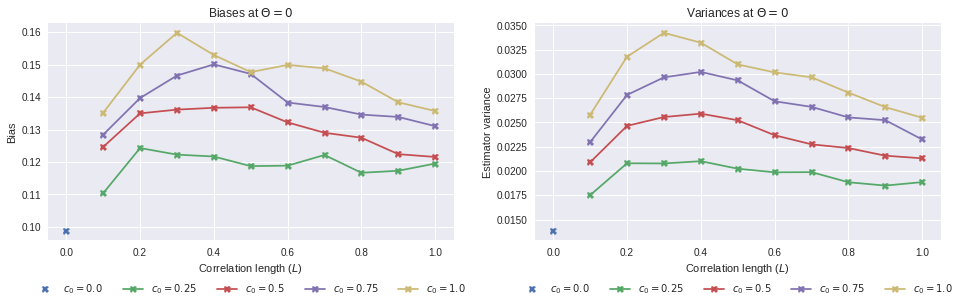

In [17]:
plt.rcParams['figure.figsize'] = (16, 4)

corr_length_arr = np.linspace(0.0, 1.0, 11)[1:]

plt.subplot(121) 
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(0.0, biases[0], 'X', label='$c_0 = 0.0$')

for max_corr in max_corr_arr:
    (biases, variances) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests_2)
    plt.plot(corr_length_arr, biases, '-X', label='$c_0 = {0}$'.format(max_corr))
    
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$')


plt.subplot(122) 
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(0.0, variances[0], 'X', label='$c_0 = 0.0$')

for max_corr in max_corr_arr:
    (biases, variances) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests_2)
    plt.plot(corr_length_arr, variances, '-X', label='$c_0 = {0}$'.format(max_corr))

plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

The above plot shows that increasing the correlation length $L$ from 0.1 initially increases the bias for encoded angle $\Theta = 0$.

We see, however, that the bias starts to decrease as the correlation length is further increased.
This appears to be the case for maximum correlation values: $c_0 \in \{0.5, 0.75, 1.0\}$.

For the correlation length range used, the bias is always greater than the uncorrelated model.

We also observe a similar behaviour with the variance.

**Next simulation will evaluate the bias for increasing correlation lengths to determine if the bias continues to decrease.**

#### Simulation 4: greater correlation length values
* Max correlation: $c_0 = 1.0$
* Correlation length: $L \in [1,10]$ using logarithmic scale

In [5]:
max_corr = 1.0

corr_length_arr = np.logspace(start=0, stop=1, num=10)
corr_length_arr = np.round(corr_length_arr, 2)

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

In [6]:
ML_ests_3 = ML_ests

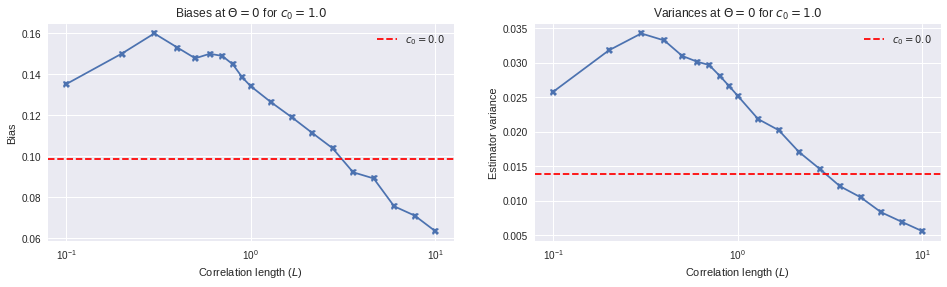

In [18]:
max_corr = 1.0

corr_length_arr_1 = np.linspace(0.0, 1.0, 11)[1:-1]
(biases_1, variances_1) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_1, ML_ests_2)

corr_length_arr_2 = np.logspace(start=0, stop=1, num=10)
corr_length_arr_2 = np.round(corr_length_arr_2, 2)
(biases_2, variances_2) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_2, ML_ests_3)

corr_length_arr = np.concatenate((corr_length_arr_1, corr_length_arr_2))
biases = np.concatenate((biases_1, biases_2))
variances = np.concatenate((variances_1, variances_2))

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 
plt.plot(corr_length_arr, biases, '-X')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='$c_0 = 0.0$')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)
plt.plot(corr_length_arr, variances, '-X')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='$c_0 = 0.0$')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

We can see that the bias and variance continue to decrease.

At approximately $L = 3.59$, the bias and variance are lower than that of the uncorrelated model.

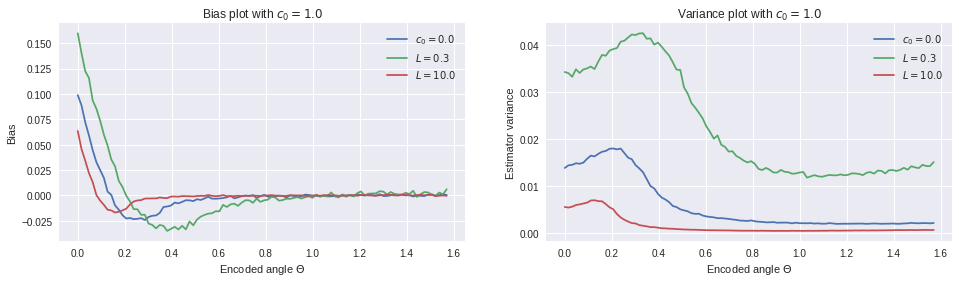

In [19]:
max_corr = 1.0
corr_length_arr = np.logspace(start=0, stop=1, num=10)
corr_length_arr = np.round(corr_length_arr_2, 2)

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = 0.0$')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = ML_ests_2[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

# idx = 5 # L=3.59 first results in bias/variance less than uncorrelated
# corr_length = corr_length_arr[idx]
# lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
# biases = ML_ests_3[lbl][1]
# plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[9]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = ML_ests_3[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias')
plt.title('Bias plot with $c_0 = 1.0$')


# Variance plot
plt.subplot(122)

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = ML_ests_2[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

# idx = 5 # L=3.59 first results in bias/variance less than uncorrelated
# corr_length = corr_length_arr[idx]
# lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
# variances = ML_ests_3[lbl][2]
# plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[9]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = ML_ests_3[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $c_0 = 1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

As $L \to \infty$, the pairwise correlations approach $1$ (this can be clearly seen in the correlation matix visualisation above) thus resembling uniform correlations.

The characteristic shape of the bias and variance across values of encoded angle $\Theta$ remain even when pairwise correlations improve accuracy.

Distribution of estimates for true stimulus value 0


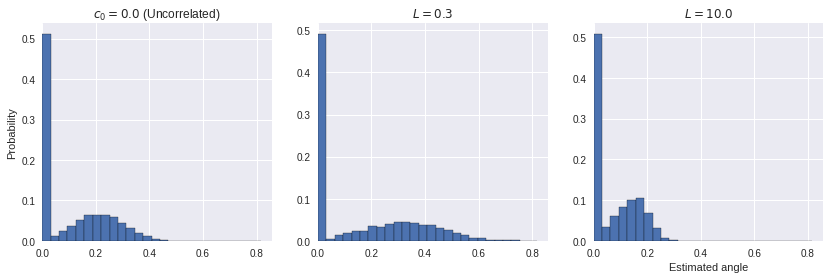

In [20]:
print('Distribution of estimates for true stimulus value 0')

plt.rcParams['figure.figsize'] = (14, 4)

max_corr = 1.0

plt.subplot(131)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
est_dist = ML_ests_1[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.ylabel('Probability')
plt.title('$c_0 = 0.0$ (Uncorrelated)')


plt.subplot(132)
corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests_2[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.title('$L = {0}$'.format(corr_length))


plt.subplot(133)
corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests_3[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('$L = {0}$'.format(corr_length))


plt.rcParams['figure.figsize'] = (10, 5)

**Simulation 5**

* Max correlation: $c_0 = 1.0$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

In [28]:
max_corr = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)

corr_length_arr_1 = corr_length_arr[:10]
corr_length_arr_2 = corr_length_arr[10:20]
corr_length_arr_3 = corr_length_arr[20:30]
corr_length_arr_4 = corr_length_arr[30:40]
corr_length_arr_5 = corr_length_arr[40:]

In [29]:
corr_length_arr = corr_length_arr_1

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_4 = ML_ests

In [30]:
corr_length_arr = corr_length_arr_2

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_5 = ML_ests

In [31]:
corr_length_arr = corr_length_arr_3

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_6 = ML_ests

In [32]:
corr_length_arr = corr_length_arr_4

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_7 = ML_ests

In [33]:
corr_length_arr = corr_length_arr_5

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_8 = ML_ests

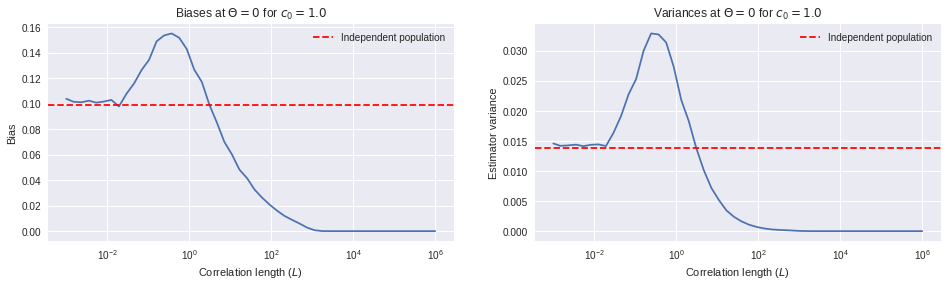

In [21]:
max_corr = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)
corr_length_arr_1 = corr_length_arr[:10]
corr_length_arr_2 = corr_length_arr[10:20]
corr_length_arr_3 = corr_length_arr[20:30]
corr_length_arr_4 = corr_length_arr[30:40]
corr_length_arr_5 = corr_length_arr[40:]

(biases_1, variances_1) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_1, ML_ests_4)
(biases_2, variances_2) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_2, ML_ests_5)
(biases_3, variances_3) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_3, ML_ests_6)
(biases_4, variances_4) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_4, ML_ests_7)
(biases_5, variances_5) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_5, ML_ests_8)


biases_theta = np.concatenate((biases_1, biases_2, biases_3, biases_4, biases_5))
variances_theta = np.concatenate((variances_1, variances_2, variances_3, variances_4, variances_5))


plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

plt.plot(corr_length_arr, biases_theta, '-')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)
plt.plot(corr_length_arr, variances_theta, '-')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

In [7]:
corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)

max_bias = np.max(biases_theta)
idx_max_bias = np.argmax(biases_theta)
corr_length_max_bias = corr_length_arr[idx_max_bias]

max_var = np.max(variances_theta)
idx_max_var = np.argmax(variances_theta)
corr_length_max_var = corr_length_arr[idx_max_var]

print('Peak bias of {0:.3f} obtained at L = {1:.3f}'.format(max_bias,corr_length_max_bias))
print('Peak variance of {0:.3f} obtained at L = {1:.3f}'.format(max_var,corr_length_max_var))

Peak bias of 0.155 obtained at L = 0.373
Peak variance of 0.033 obtained at L = 0.244


Note: Starting from correlation length 25.6 and above, the bias/variance plot against encoded angles shows oscillations above and below 0.
This is caused by the candidate estimate space (i.e. parameter grid space) not being precise enough. Changing N_CAND_EST from 100 to 1000 fixes this and the bias/variance flatlines at zero as expected.
The reason this is only an issue for higher correlation lengths is that the corresponding population responses exhibit minimal lateral fluctuation from the mean population response 'profile', only fluctuations in amplitude which do not effect the ML estimate.
Thus, the decoding distributions for certain encoded angles show a single peak with high probability (sometimes also accompanied by shallower peaks with substantially smaller probabilities).
By increasing the precision of candidate estimates, this single peak aligns more closely to the true stimulus.

The effect on the bias/variance plot against correlation length (above) for encoded stimulus 0 shouldn't be too significant since 0.0 is one of the candidate estimates. 
However, plotting the decoding distribution for certain correlation lengths does not show clearly the bell-shaped component (which is only visible for larger N_CAND_EST).
The effect of this on the mean (which contributes to the bias) shouldn't be too critical.

#### Simulation 6:
* Max correlation: $c_0 = \{0.1, 0.3, 0.5, 0.7, 0.9, 1.0\}$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

To reduce processing time, we only generate ML estimates for stimulus of 0.

In [23]:
def get_ML_ests_stim_0(cov_mtx, n_realisations=5000):
    estimate_dist = np.zeros(n_realisations)
    stim = 0.0

    # Generate noisy pop. responses by sampling multivariate distribution
    avg_pop_res = tuning_curve_theta(PREF_STIMS, stim)
    pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(PREF_STIMS, CAND_ESTS[:,None])
    tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
    errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return (bias, variance)

In [25]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

biases_theta_1 = np.zeros((len(max_corr_arr), n_corr_lengths))
variances_theta_1 = np.zeros((len(max_corr_arr), n_corr_lengths))

for i in range(len(max_corr_arr)):
    for j in range(n_corr_lengths):
        cov_mtx = construct_cov_matrix(max_corr_arr[i], corr_length_arr[j])
        (biases_theta_1[i,j], variances_theta_1[i,j]) = get_ML_ests_stim_0(cov_mtx)
        print i,j

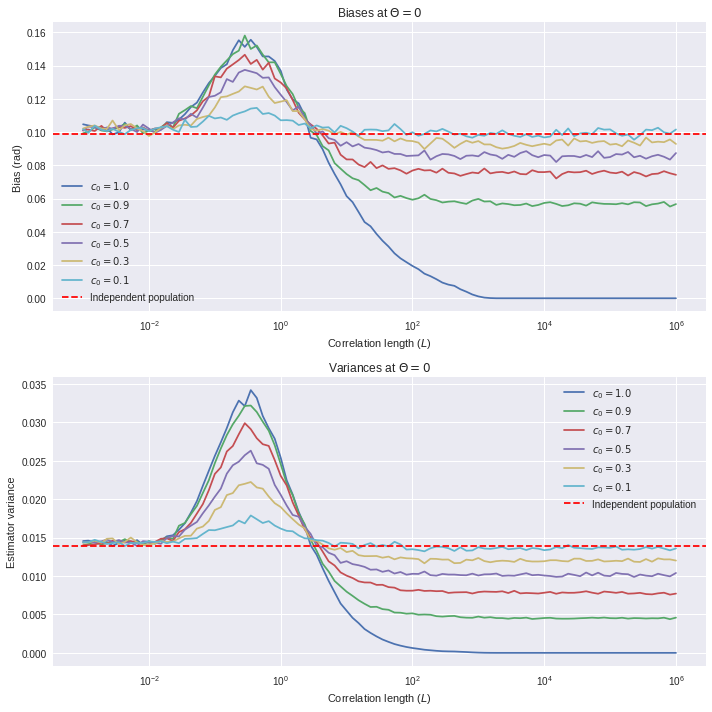

In [8]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

plt.rcParams['figure.figsize'] = (10, 10)

# Bias plot
plt.subplot(211) 

plt.plot(corr_length_arr, biases_theta_1[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, biases_theta_1[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, biases_theta_1[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, biases_theta_1[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, biases_theta_1[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, biases_theta_1[0,:], '-', label='$c_0 = 0.1$')


lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

# Variance plot
plt.subplot(212)

plt.plot(corr_length_arr, variances_theta_1[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, variances_theta_1[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, variances_theta_1[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, variances_theta_1[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, variances_theta_1[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, variances_theta_1[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

The above plots show the bias and variance for encoded angle $\Theta = 0$ across correlation length for different values of $c_0$.
These were inspired by figure 2 of (Sompolinsky et al., 2001).

### Computing estimate distribution in a numerically exact way

The probability distribution over candidate estimates for a given encoded angle, $P(\theta | \Theta)$, can be computed in a numerically exact way using a Gaussian Process approach (as explained in the referenced paper).
From the estimate distribution, the bias and variance can be calculated.

Below, we seek to validate the accuracy of this approach by comparing it to our maximum likelihood simulations for the case of correlated noise.

The estimate distributions are generated using the function `est_p_cor()` from the `DeDist` package (S. Keemink) by passing the constructed covariance matrix of our noise model as an argument.

In [28]:
def tuning_curve_theta_dedist(pref_stim, opening_angle, par):
    return tuning_curve_theta(pref_stim, opening_angle)

def get_GP_ests(cov_mtx):
    prob_dists = np.zeros((N_THETAS, N_CAND_ESTS))
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)

    fun = tuning_curve_theta_dedist
    for i in range(N_THETAS):
        stim = THETAS[i]

        prob_dist = dedist.est_p_cor(fun, stim, 0, cov_mtx, PREF_STIMS, CAND_ESTS, verbose=False)

        mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
        biases[i] = mean_est - stim
        variances[i] = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2

        prob_dists[i,:] = np.asarray(prob_dist)
        
    return [prob_dists, biases, variances]

def get_GP_ests_stim_0(cov_mtx):
    stim = 0.0
    
    fun = tuning_curve_theta_dedist
    prob_dist = dedist.est_p_cor(fun, stim, 0, cov_mtx, PREF_STIMS, CAND_ESTS, verbose=False)

    mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
    bias = mean_est - stim
    var = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2
    
    return (bias, var)

#### Experiment 1

* Uncorrelated model ($c_0 = 0$)
* $c_0 = 1.0$ with $L \in \{0.3, 10.0\}$

In [29]:
GP_ests_1 = dict()

# Uncorrelated
max_corr = 0.0
corr_length = 1.0
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

max_corr = 1.0
corr_length = 0.3
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

max_corr = 1.0
corr_length = 10.0
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

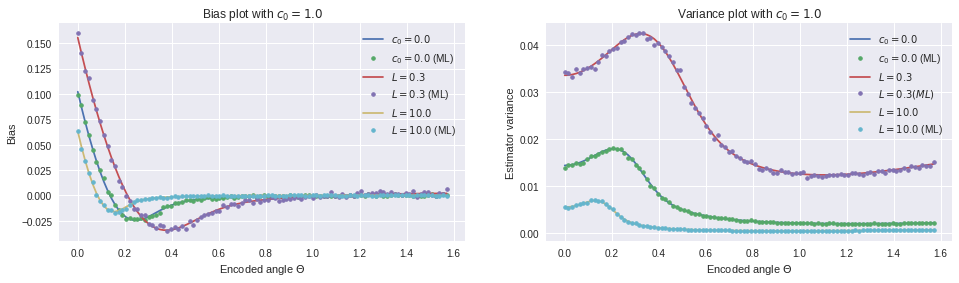

In [7]:
max_corr = 1.0

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = 0.0$')
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$c_0 = 0.0$ (ML)')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))
biases = ML_ests_2[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))
biases = ML_ests_3[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias')
plt.title('Bias plot with $c_0 = 1.0$')

# Variance plot
plt.subplot(122)

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$c_0 = 0.0$ (ML)')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))
variances = ML_ests_2[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$L = {0} (ML)$'.format(corr_length))

corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))
variances = ML_ests_3[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $c_0 = 1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

The above plots show the bias and variance across encoded angles for different correlation lengths as well as the uncorrelated model (similar to a previous plot).

They confirm that the GP approach compares well to the ML simulations.

Next, we will compare the estimate distributions for the $L = 0.3$ model above for encoded angles $0.0, 0.4, 0.8$.

Model with correlation parameters: c0 = 1.0, L = 0.3


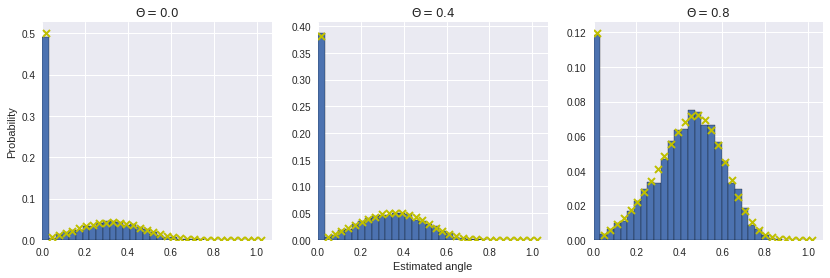

In [6]:
plt.rcParams['figure.figsize'] = (14, 4)

max_corr = 1.0
corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr, corr_length)

print('Model with correlation parameters: c0 = 1.0, L = 0.3')

upper_cand_est_idx = 33
diff_cand_est = (CAND_ESTS[1] - CAND_ESTS[0]) / 2

# Theta 0.0
plt.subplot(131)
theta_idx = 0

est_dist = ML_ests_2[lbl][theta_idx][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.ylabel('Probability')
plt.title('$\Theta = 0.0$')

# Theta 0.4
plt.subplot(132)
theta_idx = 13

est_dist = ML_ests_2[lbl][0][theta_idx,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('$\Theta = 0.4$')

# Theta 0.8
plt.subplot(133)
theta_idx = 26

est_dist = ML_ests_2[lbl][0][theta_idx,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.title('$\Theta = 0.8$')

plt.rcParams['figure.figsize'] = (10, 5)

#### Experiment 2

* Max correlation: $c_0 = \{0.1, 0.3, 0.5, 0.7, 0.9, 1.0\}$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

We shall only generate the bias and variance at $\Theta = 0$ to speed up processing time and reduce memory required.

In [35]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

biases_theta_GP = np.zeros((len(max_corr_arr), n_corr_lengths))
variances_theta_GP = np.zeros((len(max_corr_arr), n_corr_lengths))

for i in range(len(max_corr_arr)):
    for j in range(n_corr_lengths):
        cov_mtx = construct_cov_matrix(max_corr_arr[i], corr_length_arr[j])
        (biases_theta_GP[i,j], variances_theta_GP[i,j]) = get_GP_ests_stim_0(cov_mtx)
        print i,j

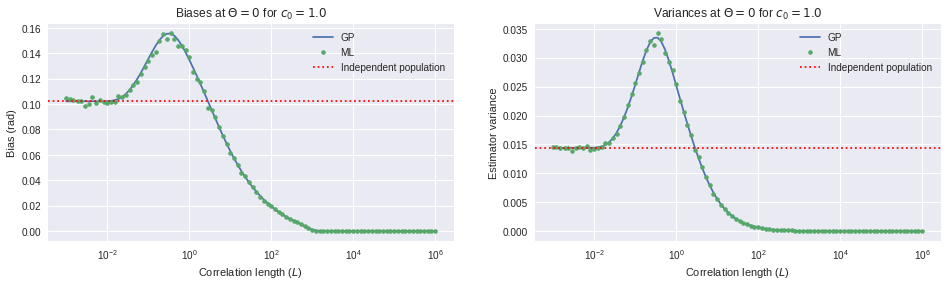

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)

max_corr = 1.0
max_corr_idx = 5 # c0 = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

# Bias plot
plt.subplot(121) 

biases = biases_theta_GP[max_corr_idx, :]
plt.plot(corr_length_arr, biases, label='GP')
plt.plot(corr_length_arr, biases_theta_1[max_corr_idx,:], '.', mew=1, label='ML')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)

variances = variances_theta_GP[max_corr_idx, :]
plt.plot(corr_length_arr, variances, label='GP')
plt.plot(corr_length_arr, variances_theta_1[max_corr_idx,:], '.', mew=1, label='ML')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

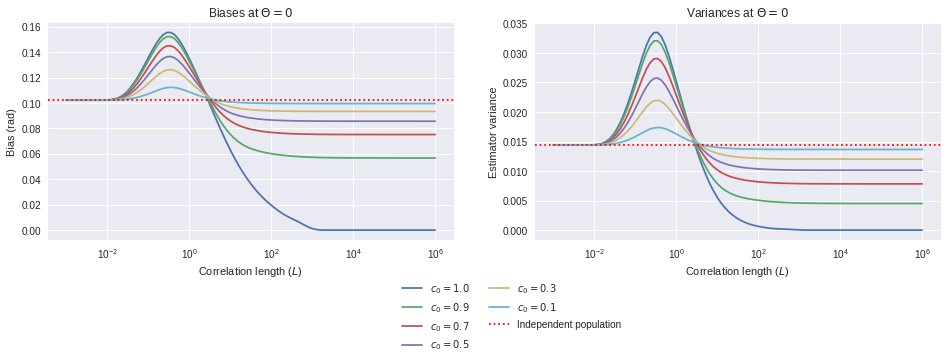

In [4]:
plt.rcParams['figure.figsize'] = (16, 4)

corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

# Bias plot
plt.subplot(121)

plt.plot(corr_length_arr, biases_theta_GP[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, biases_theta_GP[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, biases_theta_GP[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, biases_theta_GP[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, biases_theta_GP[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, biases_theta_GP[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle=':', label='Independent population')

plt.legend(loc=2, bbox_to_anchor=(0.85, -0.15), ncol=2)


plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

# Variance plot
plt.subplot(122)

plt.plot(corr_length_arr, variances_theta_GP[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, variances_theta_GP[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, variances_theta_GP[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, variances_theta_GP[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, variances_theta_GP[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, variances_theta_GP[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle=':', label='Independent population')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)